In [1]:
#importing modules
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from statsmodels.tsa.arima.model import ARIMA
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download VADER for sentiment analysis
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\shiva\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
#fetching historical data from Alpha Vantage

def fetch_stock_data(symbol, interval='daily', output_size='full'):
    api_key = "YOUR_API_KEY"
    url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&apikey={api_key}&outputsize={output_size}&datatype=json"
    
    response = requests.get(url).json()
    
    if "Time Series (Daily)" not in response:
        raise ValueError("Invalid API response. Check API Key or Symbol.")

    # Convert response to DataFrame
    df = pd.DataFrame.from_dict(response["Time Series (Daily)"], orient='index').astype(float)
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()

    return df

# Fetch stock data
stock_symbol = "JPM"
df_stock = fetch_stock_data(stock_symbol)
df_stock.head()


,1. open,2. high,3. low,4. close,5. volume
1999-11-01,86.62,87.12,83.37,83.56,4510867.0
1999-11-02,84.50,86.25,83.25,83.69,3541600.0
1999-11-03,83.62,84.00,82.19,82.44,2648800.0
1999-11-04,83.88,85.94,83.50,84.12,3869600.0
1999-11-05,86.13,87.38,85.62,86.25,3433267.0


In [3]:
#fetching latest news and perform sentiment analysis
import requests

# Replace with your actual NewsAPI key
newsapi_key = "YOUR_API_KEY"

# Stock symbol to search for
stock_symbol = "JPM"

# NewsAPI endpoint for fetching news
url = f"https://newsapi.org/v2/everything?q={stock_symbol}&language=en&sortBy=publishedAt&apiKey={newsapi_key}"

# Make request
response = requests.get(url)
news_data = response.json()

# Print the response to check for errors
print(news_data)


#Step2: news extracting
# Check if 'articles' exist in response
if "articles" in news_data and len(news_data["articles"]) > 0:
    news_or_tweet_data = [article["title"] for article in news_data["articles"]]
    print("Fetched News Headlines:")
    for i, headline in enumerate(news_or_tweet_data[:5], 1):  # Show top 5 headlines
        print(f"{i}. {headline}")
else:
    print("No articles found or API error:", news_data)
    news_or_tweet_data = []  # Avoid breaking the code

#step 3: sentiment analysis:

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np

# Initialize Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

# Perform sentiment analysis on each news headline
sentiments = [sia.polarity_scores(text)["compound"] for text in news_or_tweet_data]
sentiment_array = np.array(sentiments).reshape(-1, 1)

# Display sentiment scores
print("\nSentiment Scores:")
for i, (headline, sentiment) in enumerate(zip(news_or_tweet_data[:5], sentiments)):
    print(f"{i+1}. {headline} | Sentiment Score: {sentiment}")


{'status': 'ok', 'totalResults': 643, 'articles': [{'source': {'id': None, 'name': 'Rigzone'}, 'author': 'Andreas Exarheas', 'title': 'USA EIA Forecasts WTI Oil Price Drop in 2025 and 2026', 'description': 'According to its February STEO, the EIA sees the WTI spot price averaging $70.62 per barrel in 2025.', 'url': 'https://www.rigzone.com/news/usa_eia_forecasts_wti_oil_price_drop_in_2025_and_2026-19-feb-2025-179677-article/', 'urlToImage': 'https://images.rigzone.com/images/news/articles/USA-EIA-Forecasts-WTI-Oil-Price-Drop-in-2025-and-2026-179677-1200x628.png', 'publishedAt': '2025-02-19T12:21:13Z', 'content': 'In its latest short term energy outlook (STEO), which was released on February 11, the U.S. Energy Information Administration (EIA) projected that the West Texas Intermediate (WTI) spot price average… [+3375 chars]'}, {'source': {'id': None, 'name': 'ETF Daily News'}, 'author': 'MarketBeat News', 'title': 'Soltis Investment Advisors LLC Has $7.98 Million Stock Position in JPMo

In [4]:
#converting sentiment scores into time series

import pandas as pd
import numpy as np

# Convert sentiment scores into a DataFrame
sentiment_df = pd.DataFrame({
    "date": pd.to_datetime([article["publishedAt"][:10] for article in news_data["articles"]]),  # Extract date
    "sentiment_score": sentiments
})

# Group by date to get the average sentiment per day
sentiment_df = sentiment_df.groupby("date").mean().reset_index()

# Show sample sentiment data
print(sentiment_df.head())

        date  sentiment_score
0 2025-02-14         0.399659
1 2025-02-15         0.243763
2 2025-02-16         0.223669
3 2025-02-17         0.223631
4 2025-02-18         0.265041


In [5]:
#merging sentiment data with stock data

# Reset stock data index
df_stock.reset_index(inplace=True)
df_stock.rename(columns={"index": "date"}, inplace=True)

# Merge with sentiment data
df_combined = pd.merge(df_stock, sentiment_df, on="date", how="left")

# Fill missing sentiment scores with neutral (0)
df_combined["sentiment_score"].fillna(0, inplace=True)

df_combined.head()


C:\Users\shiva\AppData\Local\Temp\ipykernel_42216\1675776266.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_combined["sentiment_score"].fillna(0, inplace=True)


,date,1. open,2. high,3. low,4. close,5. volume,sentiment_score
0,1999-11-01,86.62,87.12,83.37,83.56,4510867.0,0.0
1,1999-11-02,84.50,86.25,83.25,83.69,3541600.0,0.0
2,1999-11-03,83.62,84.00,82.19,82.44,2648800.0,0.0
3,1999-11-04,83.88,85.94,83.50,84.12,3869600.0,0.0
4,1999-11-05,86.13,87.38,85.62,86.25,3433267.0,0.0


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

df_arima = df_stock[['date', '4. close']].set_index('date')

# Convert index to datetime format (if not already)
df_arima.index = pd.to_datetime(df_arima.index)

# Set frequency explicitly (e.g., 'B' for business days)
df_arima = df_arima.asfreq('B')  

# Fit ARIMA Model
arima_model = ARIMA(df_arima, order=(5,1,0))  # Order can be optimized
arima_fit = arima_model.fit()

# Predict next 5 business days
steps = 5
arima_forecast = arima_fit.forecast(steps=steps)

# Generate forecast dates
forecast_dates = pd.date_range(start=df_arima.index[-1], periods=steps + 1, freq='B')[1:]

# Print forecast with dates
forecast_df = pd.DataFrame({'Predicted Price': arima_forecast}, index=forecast_dates)

print("ARIMA Forecast for Next 5 Days:")
print(forecast_df)

ARIMA Forecast for Next 5 Days:
            Predicted Price
2025-02-21       267.679785
2025-02-24       267.282353
2025-02-25       267.406750
2025-02-26       267.657368
2025-02-27       267.287441


In [7]:
#preprocess data for LSTM model

# Select features: Closing price + Sentiment score
features = ["4. close", "sentiment_score"]

# Normalize data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df_combined[features])

# Convert into sequences for LSTM
X, y = [], []
time_step = 60  # Using past 60 days to predict next day

for i in range(time_step, len(scaled_data)):
    X.append(scaled_data[i-time_step:i])  # Past time steps as input
    y.append(scaled_data[i, 0])  # Future closing price as target

X, y = np.array(X), np.array(y)

# Split into training, validation, and testing
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)
test_size = len(X) - train_size - val_size

X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

print(f"Training Size: {X_train.shape}, Validation Size: {X_val.shape}, Testing Size: {X_test.shape}")


Training Size: (4413, 60, 2), Validation Size: (945, 60, 2), Testing Size: (947, 60, 2)


In [8]:
#training LSTM model

# Define LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(50),
    Dense(1)  # Predicting stock price
])

# Compile model
model.compile(optimizer="adam", loss="mean_squared_error")

# Train model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))


C:\Users\shiva\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 21s 100ms/step - loss: 0.0021 - val_loss: 3.5197e-04
Epoch 2/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - loss: 7.9008e-05 - val_loss: 3.2652e-04
Epoch 3/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 12s 85ms/step - loss: 7.8414e-05 - val_loss: 3.2851e-04
Epoch 4/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - loss: 6.0122e-05 - val_loss: 2.2477e-04
Epoch 5/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - loss: 5.7723e-05 - val_loss: 3.4085e-04
Epoch 6/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - loss: 6.0474e-05 - val_loss: 2.2447e-04
Epoch 7/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - loss: 5.8931e-05 - val_loss: 1.9979e-04
Epoch 8/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 13s 91ms/step - loss: 3.9071e-05 - val_loss: 1.5697e-04
Epoch 9/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 17s 123ms/step - loss: 4.4944e-05 - val_loss: 3.7043e-04
Epoch 10/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 13s 97ms/step - loss: 4.4293e-05 - val_loss: 1.2369e-04
Epoch 11/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step


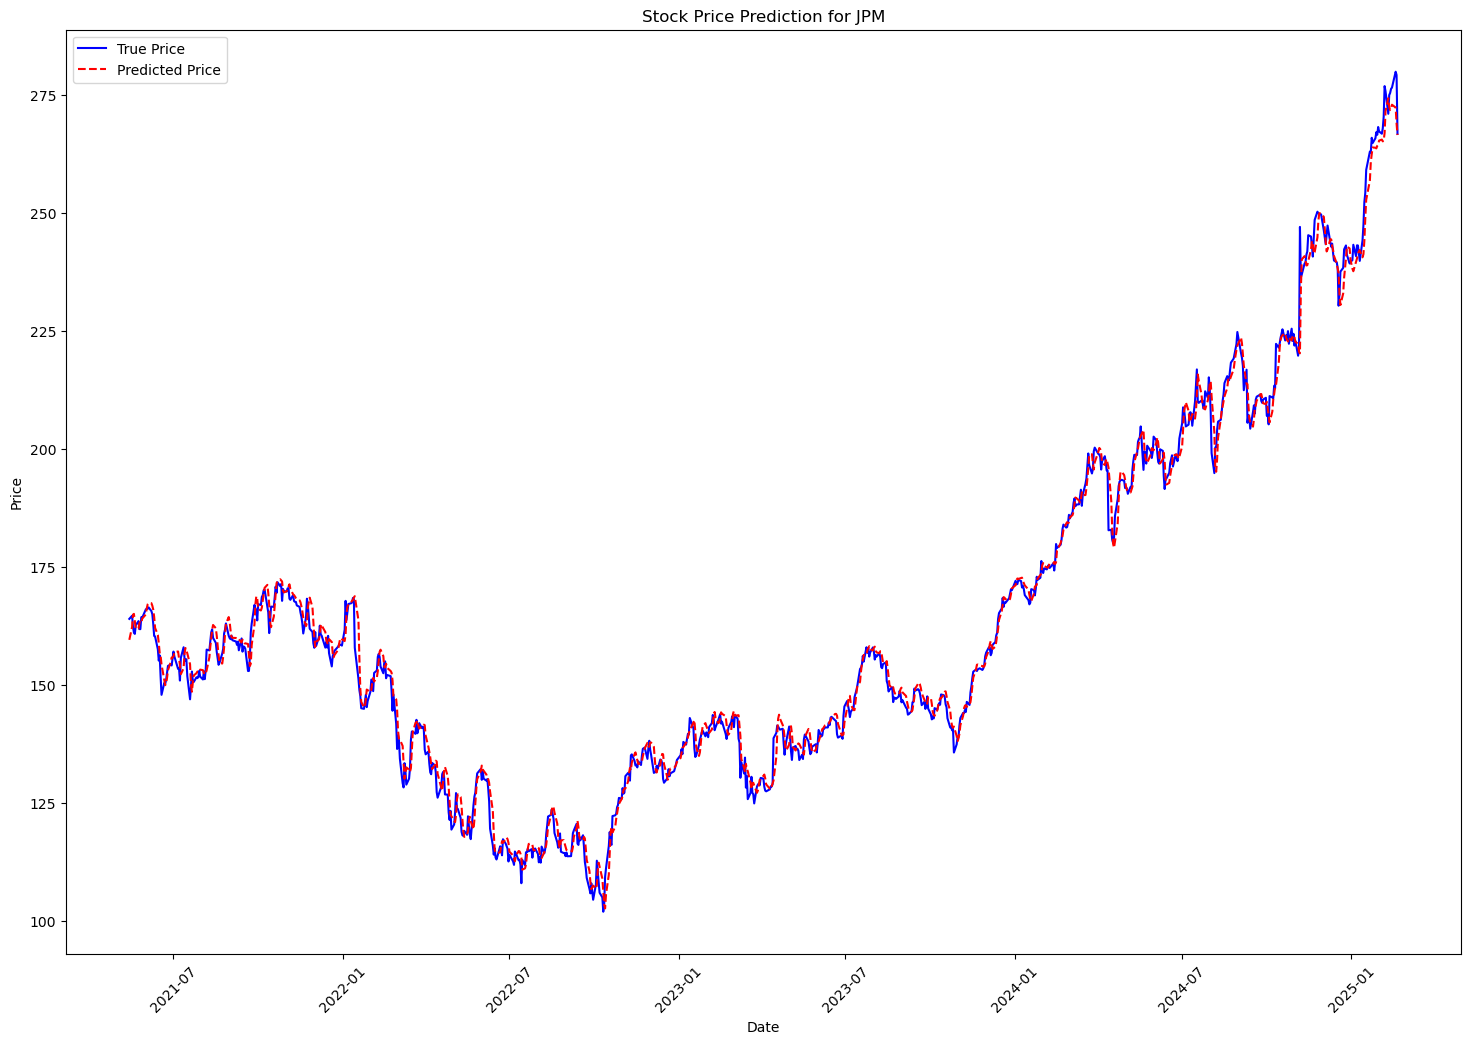

In [9]:
test_dates = df_stock['date'][-len(y_test):]  # Extract corresponding dates for test data

# Predict on test data
y_pred = model.predict(X_test)

# Reverse scaling
y_pred_rescaled = scaler.inverse_transform(np.hstack((y_pred, np.zeros((y_pred.shape[0], 1)))))[:, 0]
y_test_rescaled = scaler.inverse_transform(np.hstack((y_test.reshape(-1,1), np.zeros((y_test.shape[0], 1)))))[:, 0]

# Plot predictions with actual dates
plt.figure(figsize=(18, 12))
plt.plot(test_dates, y_test_rescaled, label="True Price", color="blue")
plt.plot(test_dates, y_pred_rescaled, label="Predicted Price", color="red", linestyle='dashed')
plt.title(f"Stock Price Prediction for {stock_symbol}")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.xticks(rotation=45)  # Rotate dates for better visibility
plt.show()
